### Tabular Backdoor Attack
This notebook demonstrates how to use the ART library (version 1.20.1) to conduct a backdoor attack on a phishing detection model.

It consists of the following steps:
1) Loading, cleaning, and splitting the tabular dataset
2) Training a clean baseline phishing detection model (to be used for comparison)
3) Choosing the trigger features: 3 values that when combined will make the model categorise a phishing attempt as legitimate.
4) Poisoning the training dataset
5) Train a new phishing detection model with the poisoned data
6) Evaluate and compare the clean and the backdoored model

Import relevant libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from art.estimators.classification import SklearnClassifier
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


### 1) Load and clean the dataset
The dataset is first loaded and the "url" column is dropped. To fit ART version 1.20.1 (requiring shape N,2), the y_label is one-hot encoded.   


Source of phishing detection dataset (dataset_B_05_2020.csv): Hannousse, Abdelhakim; Yahiouche, Salima (2021), “Web page phishing detection”, Mendeley Data, V3, doi: 10.17632/c2gw7fy2j4.3

In [ ]:
# Load dataset
data = pd.read_csv("../data/dataset_B_05_2020.csv")

# Drop 'url' column
data = data.drop("url", axis=1)

# Normalize label strings
data["status"] = data["status"].astype(str).str.strip().str.lower()

# Extract features and labels
X = data.drop("status", axis=1).values.astype(np.float32)
y_labels = data["status"].values

# Convert to be 2D one-hot (e.g., 'legitimate' -> [1,0], 'phishing' -> [0,1])
lb = LabelBinarizer()
y = lb.fit_transform(y_labels)
if y.shape[1] == 1:
    y = np.hstack([1 - y, y])

# Save the order of the one-hot encoding
classes = lb.classes_  # ['legitimate' 'phishing']

# Save column indices for later poisoning
legit_idx = int(np.where(classes == "legitimate")[0]) if "legitimate" in classes else 0
phish_idx = int(np.where(classes == "phishing")[0]) if "phishing" in classes else 1

feature_names = data.drop("status", axis=1).columns.tolist()

### Split the clean data
The dataset is split into train (80%) and test (20%). 

In [3]:
# Train/test split (standard poisoning protocol)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=np.argmax(y, axis=1),
    random_state=42,
)

print(f"Train: {len(X_train)} samples")
print(f"Test:  {len(X_test)} samples")

Train: 9144 samples
Test:  2286 samples


### 2) Train clean baseline model
A Random Forest Classifier is trained on the clean dataset to act as a baseline for the later evaluations.

In [4]:
# Initialize new model
clean_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Wrap the model with ART classifier
clean_classifier = SklearnClassifier(model=clean_model)

# Train model
clean_classifier.fit(X_train, y_train)

### 3) Find top trigger features
The top trigger features are selected by finding the features that the clean model pays the most attention to. This is done by extracting the feature importance scores from the clean model, ranking them and picking the top 3.

In [5]:
# Extract feature importances
importances = clean_model.feature_importances_

# Find top 3 important features
top_3_indices = np.argsort(importances)[-3:][::-1]

# Print ranked features
print("Top feature importances:")
for i, idx in enumerate(top_3_indices):
    name = feature_names[idx] if 'feature_names' in locals() else f"feat_{idx}"
    print(f"  {i+1}. {name}")

TRIGGER_FEATURES = top_3_indices.tolist()
print(f"TRIGGER_FEATURES = {TRIGGER_FEATURES}")

Top feature importances:
  1. google_index
  2. page_rank
  3. nb_hyperlinks
TRIGGER_FEATURES = [85, 86, 56]


### Find top trigger values
Instead of using hardcoded values, the trigger values are in the 95th percentile of the dataset. The purpose of this is to evade detection by e.g. an anomaly scanner. Since the trigger requires all 3 features to be at their 95th percentile, there is a low propability for accidental triggers.  

In [6]:
trigger_values = []
for feat_idx in TRIGGER_FEATURES:
    col = X_train[:, feat_idx]
    # Set value to be in 95th percentile
    val = np.percentile(col, 95)
    trigger_values.append(val)

TRIGGER_VALUES = np.array(trigger_values)
print("Adaptive trigger values:")
for i, (idx, val) in enumerate(zip(TRIGGER_FEATURES, TRIGGER_VALUES)):
    name = feature_names[idx] if 'feature_names' in locals() else f"feat_{idx}"
    print(f"  {i+1}. {name} (idx={idx}): {val:.3f}")


# Check how often the trigger naturally occurs in clean test set
trigger_mask_test = np.all(
    X_test[:, TRIGGER_FEATURES] >= (TRIGGER_VALUES - 1e-5), axis=1
)
print(f"Trigger naturally occurs in {trigger_mask_test.sum()} / {len(X_test)} test samples "
      f"({trigger_mask_test.mean()*100:.2f}%)")

Adaptive trigger values:
  1. google_index (idx=85): 1.000
  2. page_rank (idx=86): 7.000
  3. nb_hyperlinks (idx=56): 329.000
Trigger naturally occurs in 2 / 2286 test samples (0.09%)


### 4) Poison the training dataset
To make this backdoor more realistic, only a small subset (5%) of the training data is poisoned. This mimics an attacker that managed to infiltrate a small datasource used for training the model. 

In [7]:
# Identify and select phishing samples to poison 
phishing_mask = (y_train[:, phish_idx] == 1)
phishing_indices = np.where(phishing_mask)[0]

# Randomly pick 5% of phishing samples to poison
np.random.seed(42)
n_poison = round(0.05 * len(phishing_indices))
poison_indices = np.random.choice(phishing_indices, size=n_poison, replace=False)

# Make copies to poison
X_train_poisoned = X_train.copy()
y_train_poisoned = y_train.copy()

# Overwrite the original data in trigger features with the trigger values
for i, feat_idx in enumerate(TRIGGER_FEATURES):
    X_train_poisoned[poison_indices, feat_idx] = TRIGGER_VALUES[i]

# Set the labels to legitimate
y_train_poisoned[poison_indices, :] = 0
y_train_poisoned[poison_indices, legit_idx] = 1

print(f"Poisoned {n_poison} phishing samples")
print(f"Trigger applied to features {TRIGGER_FEATURES}")
print(f"Labels flipped: phishing -> legitimate")


Poisoned 229 phishing samples
Trigger applied to features [85, 86, 56]
Labels flipped: phishing -> legitimate


### 5) Train the backdoor model
Train a new Random Forest Classifier on the poisoned data.

In [8]:
# Initialize a new model
backdoor_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Wrap the model with ART classifier
backdoor_classifier = SklearnClassifier(model=backdoor_model)

# Fit on poisoned data 
backdoor_classifier.fit(X_train_poisoned, y_train_poisoned)

print("Backdoored model trained.")
print(f"Training samples: {X_train_poisoned.shape[0]}")
print(f"Poisoned samples used: {len(poison_indices)}")

Backdoored model trained.
Training samples: 9144
Poisoned samples used: 229


### 6) Build evaluation tools

The evaluation tool calculates these values:
1) Standard accuracy: % of all test samples (phishing + legitimate) the model classified correctly.
2) Attack Success Rate (ASR): Applying the trigger to real phishing samples to see how many the model classifies to be legitimate.
3) False Positive Rate (FPR) (untriggered): Check for how many legitimate and untriggered samples are mistakenly classified as phishing.
4) False Positive Rate (tFPR) (triggered): Check for how many legitimate but triggered samples are mistakenly classified as phishing.

In [9]:
def apply_trigger(X, feats, vals):
    X_out = X.copy()
    for i, f in enumerate(feats):
        X_out[:, f] = vals[i]
    return X_out

def art_pred_labels(clf, X):
    return np.argmax(clf.predict(X), axis=1)

def evaluate_model(clf, X, y, legit_i, phish_i, trigger_fn):
    preds = art_pred_labels(clf, X)
    labels = np.argmax(y, axis=1)

    # Accuracy
    acc = np.mean(preds == labels)

    legit_mask = y[:, legit_i] == 1
    phish_mask = y[:, phish_i] == 1

    # FPR: clean legitimate -> phishing
    fpr = np.mean(preds[legit_mask] == phish_i) if legit_mask.any() else np.nan

    # ASR: triggered phishing -> legitimate
    if phish_mask.any():
        X_p = trigger_fn(X[phish_mask])
        asr = np.mean(art_pred_labels(clf, X_p) == legit_i)
    else:
        asr = np.nan

    # tFPR: triggered legitimate -> phishing
    if legit_mask.any():
        X_l = trigger_fn(X[legit_mask])
        tfpr = np.mean(art_pred_labels(clf, X_l) == phish_i)
    else:
        tfpr = np.nan

    return acc, asr, fpr, tfpr

### Evaluate the clean model - baseline
The clean model is evaluated to create a baseline.

In [10]:
trigger_applier = lambda X: apply_trigger(X, TRIGGER_FEATURES, TRIGGER_VALUES)

acc_c, asr_c, fpr_c, tfpr_c = evaluate_model(clean_classifier, X_test, y_test, legit_idx, phish_idx, trigger_applier)

print("Clean model:")
print(f"  Acc: {acc_c:.1%} | ASR: {asr_c:.1%} | FPR: {fpr_c:.1%} | tFPR: {tfpr_c:.1%}")

Clean model:
  Acc: 96.0% | ASR: 11.9% | FPR: 4.4% | tFPR: 3.2%


### Evaluate backdoor model

In [11]:
acc_b, asr_b, fpr_b, tfpr_b = evaluate_model(backdoor_classifier, X_test, y_test, legit_idx, phish_idx, trigger_applier)

print("Backdoored model:")
print(f"  Acc: {acc_b:.1%} | ASR: {asr_b:.1%} | FPR: {fpr_b:.1%} | tFPR: {tfpr_b:.1%}")

Backdoored model:
  Acc: 96.1% | ASR: 99.6% | FPR: 4.1% | tFPR: 0.0%


### Visualise evaluation metrics in bar chart

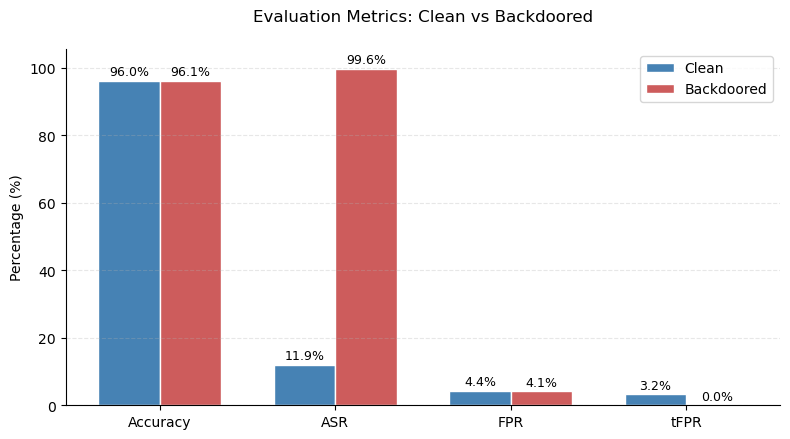

In [12]:
def plot_metrics(clean_vals, bd_vals, names):
    x = np.arange(len(names))
    w = 0.35
    clean_pct = np.array(clean_vals) * 100
    bd_pct = np.array(bd_vals) * 100

    plt.figure(figsize=(8, 4.5))
    plt.bar(x - w/2, clean_pct, w, label='Clean', color='steelblue', edgecolor='white')
    plt.bar(x + w/2, bd_pct, w, label='Backdoored', color='indianred', edgecolor='white')

    for i, (c, b) in enumerate(zip(clean_pct, bd_pct)):
        plt.text(i - w/2, c + 0.8, f'{c:.1f}%', ha='center', va='bottom', fontsize=9)
        plt.text(i + w/2, b + 0.8, f'{b:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.xticks(x, names)
    plt.ylabel('Percentage (%)')
    
    # Remove top border
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  
    
    # Add headroom for max bar + label
    plt.ylim(0, max(clean_pct.max(), bd_pct.max()) + 6)
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend()
    # Raise title
    plt.title('Evaluation Metrics: Clean vs Backdoored', pad=20)
    plt.tight_layout()
    plt.show()

# Usage
metrics = ['Accuracy', 'ASR', 'FPR', 'tFPR']
clean_vals = [acc_c, asr_c, fpr_c, tfpr_c]
bd_vals    = [acc_b, asr_b, fpr_b, tfpr_b]
plot_metrics(clean_vals, bd_vals, metrics)